In [37]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
font = {'size'   : 16}
matplotlib.rc('font', **font)

import sqlite3
import pandas as pd
from src import clean_data as d
conn = sqlite3.connect('data/billboard-200.db')

In [23]:
albums_table, albums, artists, songs = d.get()
song_parameters = d.song_parameters
normal_parameters = d.normal_parameters

In [24]:
def weighted_score(param, chart):
    power_rank_col = chart['power']
    param_col = chart[param]
    return (power_rank_col * param_col).sum() / power_rank_col.sum()

In [25]:
weekly_charts = albums_table.merge(albums, 
                                   on=['album','artist'], 
                                   how='left'
                                  ).groupby('date')
week_scores = []
week_dates = []
for date, chart in weekly_charts:
        params = {p:0 for p in song_parameters}
        for p in params:
            params[p] = weighted_score(p, chart)
            
        week_scores.append(params)
        week_dates.append(date)
        
# Timeseries containing the scores for every week
parameter_ts = pd.DataFrame(week_scores, index=week_dates)

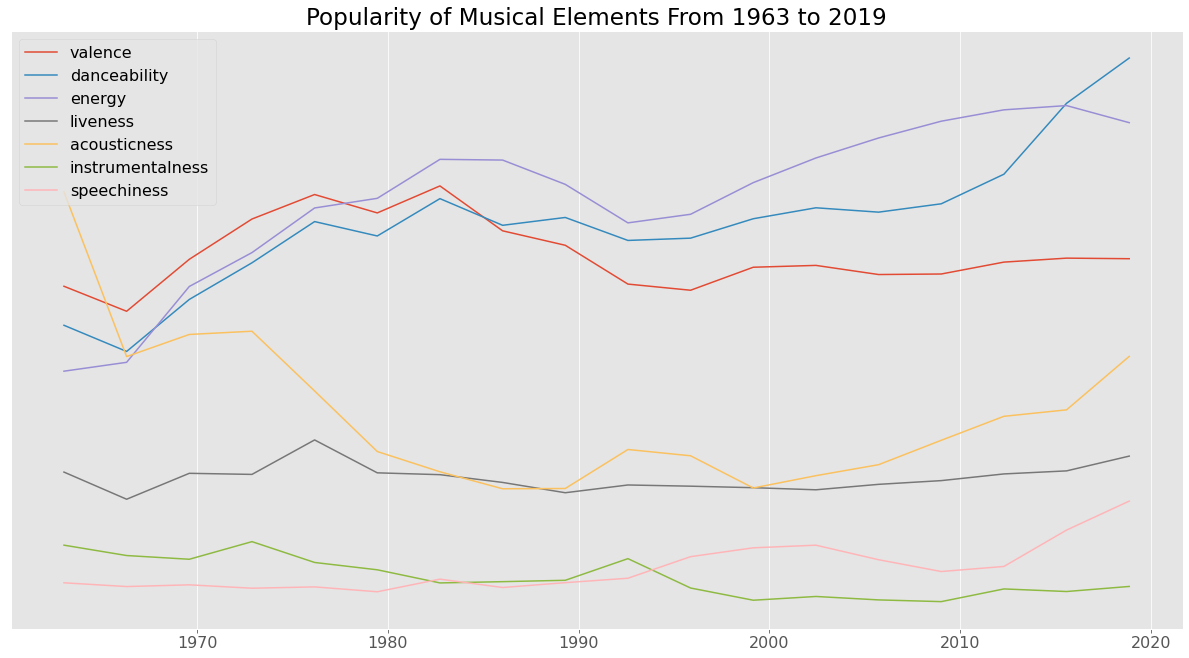

In [39]:
# Resample timeseries by every 1200 days to smooth out noise
resampled = parameter_ts.resample(pd.Timedelta(1200,'day')).mean()
fig, ax = plt.subplots(figsize=(21, 11))
for p in normal_parameters:
    ax.plot(resampled.index, resampled[p])

ax.set_title('Popularity of Musical Elements From 1963 to 2019')
ax.set_ylabel('Popularity')
ax.get_yaxis().set_visible(False)
ax.legend(normal_parameters);